#### KNN and K-Means Algorithm
> The purpose of this notebook is to explore the implementation of the KNN and K-means algorithms as a means of clustering data. I am going to apply the KNN algorithm to a dataset on credit card approvals and the K-Means algorithm on the classic Iris dataset. The KNN model is a supervised model meaning that the correct classifications will be known and used to tune the model. The K-Means model is unsupervised but I will use the known flower species to evaluate the model in the end.

### Part 1 - KNN on Credit Card Data

#### Install Libraries
This notebook needs the kernlab and kknn libraries, I also included the vtable library to get information about the data, the htmltools library to print out the notebook, and the ggplot2 library to help plot results.

In [35]:
library(kernlab)
library(kknn)
library(caret)
library(ggplot2)
library(datasets)
library(factoextra)
library(tidyverse)

#### Load Data

In [2]:
data <- read.table("credit_card_data-headers.txt", header = TRUE)

#### Examine Data
Now that the data is loaded I want to examine it to get a better idea of what it looks like. I'm interested in actually seeing the data but also infomration about the data such as data type and ranges of values.

In [3]:
# Output the data class for each column transposed
t(sapply(data, class))

A1,A2,A3,A8,A9,A10,A11,A12,A14,A15,R1
integer,numeric,numeric,numeric,integer,integer,integer,integer,integer,integer,integer


In [4]:
# Look at the first and last few rows of the data
head(data)
tail(data)

A1,A2,A3,A8,A9,A10,A11,A12,A14,A15,R1
1,30.83,0.000,1.25,1,0,1,1,202,0,1
0,58.67,4.460,3.04,1,0,6,1,43,560,1
0,24.50,0.500,1.50,1,1,0,1,280,824,1
1,27.83,1.540,3.75,1,0,5,0,100,3,1
1,20.17,5.625,1.71,1,1,0,1,120,0,1
1,32.08,4.000,2.50,1,1,0,0,360,0,1


,A1,A2,A3,A8,A9,A10,A11,A12,A14,A15,R1
649,1,40.58,3.290,3.50,0,1,0,0,400,0,0
650,1,21.08,10.085,1.25,0,1,0,1,260,0,0
651,0,22.67,0.750,2.00,0,0,2,0,200,394,0
652,0,25.25,13.500,2.00,0,0,1,0,200,1,0
653,1,17.92,0.205,0.04,0,1,0,1,280,750,0
654,1,35.00,3.375,8.29,0,1,0,0,0,0,0


In [5]:
# Output the range of all the values for each column as a table
t(sapply(data, range))

A1,0.00,1.00
A2,13.75,80.25
A3,0.00,28.00
A8,0.00,28.50
A9,0.00,1.00
A10,0.00,1.00
A11,0.00,67.00
A12,0.00,1.00
A14,0.00,2000.00
A15,0.00,100000.00
R1,0.00,1.00


In [6]:
# Check that the R1 column only contains 1 and 2 and output a summary table (doesn't show in notebook)
unique(data$R1)
summary(data)

[1] 1 0

       A1               A2              A3               A8        
 Min.   :0.0000   Min.   :13.75   Min.   : 0.000   Min.   : 0.000  
 1st Qu.:0.0000   1st Qu.:22.58   1st Qu.: 1.040   1st Qu.: 0.165  
 Median :1.0000   Median :28.46   Median : 2.855   Median : 1.000  
 Mean   :0.6896   Mean   :31.58   Mean   : 4.831   Mean   : 2.242  
 3rd Qu.:1.0000   3rd Qu.:38.25   3rd Qu.: 7.438   3rd Qu.: 2.615  
 Max.   :1.0000   Max.   :80.25   Max.   :28.000   Max.   :28.500  
       A9              A10              A11              A12        
 Min.   :0.0000   Min.   :0.0000   Min.   : 0.000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.: 0.000   1st Qu.:0.0000  
 Median :1.0000   Median :1.0000   Median : 0.000   Median :1.0000  
 Mean   :0.5352   Mean   :0.5612   Mean   : 2.498   Mean   :0.5382  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.: 3.000   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :1.0000   Max.   :67.000   Max.   :1.0000  
      A14               A15              

In [7]:
# Double check size of the data
cat('Rows',' ','Columns')
t(dim(data))

Rows   Columns

654,11


This lets me know that I have a table with 654 rows and 11 columns (10 attributes and one result). The data is a combination of integer and float (numeric) values with A1, A9, A10, A12, and R1 being categorical (1 or 0). Looking at the UC Irvine website linked above, they list information about the dataset and I can see that our dataset has been cleaned. Missing values have been removed, categorical variables with more than 2 categories have been dropped, and categories have been turned into numerical values (1 or 0). It's also important to note the wide range in values that some of our attributes possess, meaning scaling will be important. I also know that this dataset is being using to determine credit approval for credit card applications.

### Cross-Validation for KNN model
Next I am going to use cross validation to deteremine the best k-value for our KNN model. To do this I'll follow the steps below:
1) Split data into 20% for testing and 80% for training and validation
2) Split the training and validation data up into 10 folds (using k=10 since that is "common")
3) For each k-value rotate through the training/validation data using 9 of the folds for training and 1 for validation, storing the average validation accuracy for each k-value
4) Compare the average accuracy for each model to deteremine which k-value to use for our model
5) Once the model hyperparameters (k-value) has been selected train the KNN model using the entire training/validation data
6) Test the model using the testing data to predict it's overall accuracy

#### Step 1 - Split data
I choose to split the data into 20% for testing and 80% for training/validation using the random method (vs. rotation). To do this I used the sample function in R which generates random elements from the given data. I found that the examples and explanation on these websites helpful in implementation: 
1) https://www.geeksforgeeks.org/how-to-generate-a-sample-using-the-sample-function-in-r/
2) https://stackoverflow.com/questions/17200114/how-to-split-data-into-training-testing-sets-using-sample-function

In [8]:
# Using set.seed() insures that we get the same results each run since the values are randomly selected
set.seed(123)

# Get the size for the testing dataset
test_data_size <- floor(0.20 * nrow(data))

# Generate random indices that represent 20% of the data
test_ind <- sample(seq_len(nrow(data)), size = test_data_size)

# Assign data to the testing and train/validatino sets
testing_data <- data[test_ind, ]
training_data <- data[-test_ind, ]

Now that I have my training/validation and testing datasets I am going to inspect them. I want to double check the size of the datasets and also inspect the summary statistics for each dataset. Note that the sumtable() function outputs a .html object that I had to insert into the notebook.

In [9]:
cat("The size of the training/validation set is", nrow(training_data), "and the size of the testing dataset is", nrow(testing_data))
cat("\n")
cat("The total size of both datasets should be", nrow(data), "and is", nrow(training_data) + nrow(testing_data), "\n")
cat("\n")
cat("Summary of testing dataset:")
cat("\n")
summary(testing_data)
cat("\n")
cat("Summary of training/validation dataset:")
cat("\n")
summary(training_data)

The size of the training/validation set is 524 and the size of the testing dataset is 130
The total size of both datasets should be 654 and is 654 

Summary of testing dataset:


       A1               A2              A3               A8        
 Min.   :0.0000   Min.   :15.17   Min.   : 0.000   Min.   : 0.000  
 1st Qu.:0.0000   1st Qu.:21.81   1st Qu.: 1.000   1st Qu.: 0.165  
 Median :1.0000   Median :27.45   Median : 2.855   Median : 1.125  
 Mean   :0.6615   Mean   :31.67   Mean   : 4.810   Mean   : 2.503  
 3rd Qu.:1.0000   3rd Qu.:38.50   3rd Qu.: 7.000   3rd Qu.: 3.312  
 Max.   :1.0000   Max.   :76.75   Max.   :22.290   Max.   :16.000  
       A9              A10              A11             A12        
 Min.   :0.0000   Min.   :0.0000   Min.   : 0.00   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.: 0.00   1st Qu.:0.0000  
 Median :1.0000   Median :1.0000   Median : 0.00   Median :1.0000  
 Mean   :0.5615   Mean   :0.5462   Mean   : 2.50   Mean   :0.5846  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.: 3.75   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :1.0000   Max.   :16.00   Max.   :1.0000  
      A14             A15                R1     


Summary of training/validation dataset:


       A1               A2              A3               A8         
 Min.   :0.0000   Min.   :13.75   Min.   : 0.000   Min.   : 0.0000  
 1st Qu.:0.0000   1st Qu.:22.67   1st Qu.: 1.040   1st Qu.: 0.1988  
 Median :1.0000   Median :28.58   Median : 2.812   Median : 1.0000  
 Mean   :0.6966   Mean   :31.55   Mean   : 4.836   Mean   : 2.1768  
 3rd Qu.:1.0000   3rd Qu.:38.19   3rd Qu.: 7.521   3rd Qu.: 2.5513  
 Max.   :1.0000   Max.   :80.25   Max.   :28.000   Max.   :28.5000  
       A9              A10              A11              A12        
 Min.   :0.0000   Min.   :0.0000   Min.   : 0.000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.: 0.000   1st Qu.:0.0000  
 Median :1.0000   Median :1.0000   Median : 0.000   Median :1.0000  
 Mean   :0.5286   Mean   :0.5649   Mean   : 2.498   Mean   :0.5267  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.: 3.000   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :1.0000   Max.   :67.000   Max.   :1.0000  
      A14              A15        

#### Step 2 - Split the Training and Validation Data up Into K-Folds
Next I'll split the training_data into 10 folds. The createFolds function from the caret library returns a list of folds which each fold being a list of indices.

In [10]:
# Create n folds of the training_data
n_folds = 10
folds <- createFolds(training_data[,11], k = n_folds, list = TRUE, returnTrain = FALSE)

#### Step 3 - Train and Validate our Model for a Range of k-values
Next I am going to train and validate tge model for various k-values using k-fold validation of the training_data. The average validation result for each k-value will be stored in a dataframe that can be analyzed after to deteremine which hyperparameter (k-value) to use.

In [11]:
# Setup paramaters and results dataframe for KNN model
k_len = 60
knn_results_df <- data.frame('k_value' = numeric(), 'Accuracy' = numeric(), stringsAsFactors = FALSE)

# Loop through k-values and use cross validation to capture the average accuracy
for (k_val in 1:k_len) {
    # Create numeric vector to store accuracies for each k-value
    accuracies <- numeric(n_folds)
    
    # Loop through each fold setting one fold as validation and the others as training
    for (i in 1:n_folds) {
        # Have to unpack the folds because they are lists of indices
        train_indices <- unlist(folds[-i])
        validation_indices <- unlist(folds[i])
        
        # Create the training and validation dataset for the current fold
        train_data <- training_data[train_indices, ]
        validation_data <- training_data[validation_indices, ]
        
        # Train the model for the given k-value and fold
        knn_model = kknn(as.factor(R1)~., train_data, validation_data, k=k_val, scale = TRUE)
        
        # Predict the results of the validation_dataset and calculate the accuracy for the given k-value and fold
        predictions <- predict(knn_model)
        accuracy <- sum(predictions == validation_data$R1) / nrow(validation_data)
        accuracies[i] <- accuracy
    }

    # Calculate average accuracy over all the folds for the given the k-value
    avg_accuracy <- mean(accuracies)
  
    # Store results in the dataframe
    knn_results_df <- rbind(knn_results_df, data.frame('k_value' = k_val, 'Accuracy' = avg_accuracy))
}

# Print the head of the results dataframe
head(knn_results_df)

k_value,Accuracy
1,0.7943033
2,0.7943033
3,0.7943033
4,0.7943033
5,0.8398403
6,0.8359579


#### Step 4 - Analyze the Results
Next I want to look at the results on a graph so I can visually see what is happening with the various k-values. I also am going to print out the maximum accuracy value and the corresponding k-value.

Maximum Accuracy value: 0.8512337 
Corresponding k-value: 22 


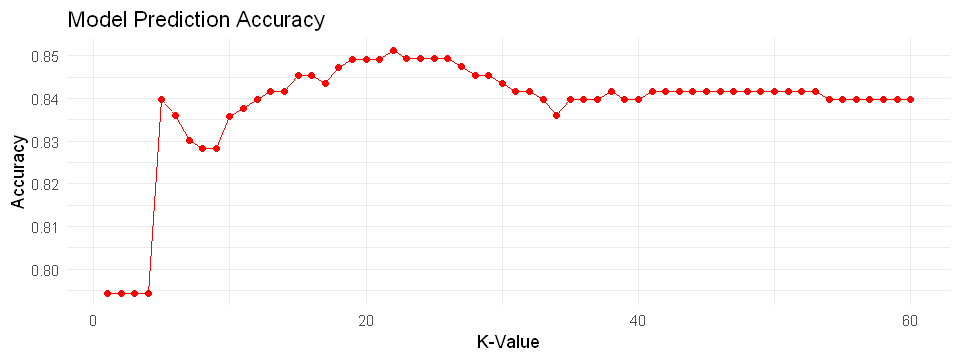

In [12]:
# Create a graph of k-values vs. accuracy
options(repr.plot.width = 8, repr.plot.height = 3)
ggplot(data = knn_results_df, aes(x = k_value, y = Accuracy)) +
  geom_point(color = "red") + 
  geom_line(color = "red") +
  labs(x = "K-Value", y = "Accuracy", title = "Model Prediction Accuracy") +
  theme_minimal()

# Find the row index with the maximum Accuracy and the corresponding K-Value
max_index <- which.max(knn_results_df$Accuracy)
max_k_value <- knn_results_df$k_value[max_index]
max_accuracy <- knn_results_df$Accuracy[max_index]

# Print the results
cat("Maximum Accuracy value:", max_accuracy, "\n")
cat("Corresponding k-value:", max_k_value, "\n")

#### Step 5 - Train KNN Model on Entire Training/Validation Dataset
Based on the results above I selected a **k-value of 22** for the model. Now that we have k-value we will create a new model using the entire training/validation dataset.

In [13]:
# Train the model for the given k-value and fold
knn_model = kknn(as.factor(R1)~., training_data, testing_data, k=22, scale = TRUE)

#### Step 6 - Check Accuracy for Final Model
The last thing to do is to use the model to predict outcomes using the testing data and then look at how they compare to the expected outcomes.

In [14]:
# Predict the results of the validation_dataset and calculate the accuracy for the given k-value and fold
predictions <- predict(knn_model)
accuracy <- 100 * sum(predictions == testing_data$R1) / nrow(testing_data)
cat("Using a k-value of 22 our model has an accuracy of",round(accuracy, 2),"%")

Using a k-value of 22 our model has an accuracy of 85.38 %

In summary, I split the data into training/validation (80%) and testing (20%). Then I used cross validation with 10 folds to compare KNN models with k-values ranging from 1 to 60 on the training/validation data. I found that a **k-value of 22** provided the highest accuracy during validation. Once the model was selected, I created a new KNN model trained on the entire training/validation dataset and checked the accuracy of that model using the testing dataset which resulted in an overall **model accuracy of 85.38%**. It is important to note that the expected accuracy of this model will be less than that since the model is slightly biased towards the randomness of the validation set that was used to select it.

### Step 2 - K-Means on Iris Dataset

#### Load Data
The Iris data set comes from the dataset library provided with R.

In [15]:
iris_data <- iris

#### Examine Iris Data
Now that the data is loaded I want to examine it to get a better idea of what it looks like. I'm interested in actually seeing the data but also infomration about the data such as data type and ranges of values. The summary() function gives summary statistics for any dataset and the str() function provides information about the dataframe.

In [16]:
summary(iris_data)
str(iris_data)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.057   Mean   :3.758   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
       Species  
 setosa    :50  
 versicolor:50  
 virginica :50  
                
                
                

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


In [17]:
# Output the data class for each column transposed
t(sapply(iris_data, class))

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
numeric,numeric,numeric,numeric,factor


In [18]:
# Look at the first and last few rows of the data
head(iris_data)
tail(iris_data)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
145,6.7,3.3,5.7,2.5,virginica
146,6.7,3.0,5.2,2.3,virginica
147,6.3,2.5,5.0,1.9,virginica
148,6.5,3.0,5.2,2.0,virginica
149,6.2,3.4,5.4,2.3,virginica
150,5.9,3.0,5.1,1.8,virginica


In [19]:
# Check that the Species column for all of the possible outcomes
unique(iris_data$Species)

[1] setosa     versicolor virginica 
Levels: setosa versicolor virginica

In [20]:
# Double check size of the data
cat('Rows',' ','Columns')
t(dim(iris_data))

Rows   Columns

150,5


This lets me know that I have a table with 150 rows and 5 columns (4 attributes and one result). The data is a combination of float (numeric) values and one factor (species). I also know that this dataset is being using to determine plant species based on sepal length, sepal width, petal length, and petal width.

### Cluster Model of Iris Dataset
Next I am going to use the kmeans function in R to deteremine the optimal k-value, the best combination of predictors, and analyze how well the model predicts flower species. I found the information provided at https://www.geeksforgeeks.org/k-means-clustering-in-r-programming/ useful for creating this model. The steps I am going to take to create and analyze the model are shown below:
1) Standardize the data
2) Look at clustering distance measures
3) Determine the optimal k-value using the elbow method
4) Look at the 4 variables to determine the best combination of predictors
5) Analyze preformance of the model

In [21]:
str(iris_data)
cat("\n")
summary(iris_data)

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...



  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.057   Mean   :3.758   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
       Species  
 setosa    :50  
 versicolor:50  
 virginica :50  
                
                
                

#### Step 1 - Prepare the Data

In [22]:
# Remove the species from the data since this should be unsupervised learning
iris_variables <- iris_data[,-5]
summary(iris_variables)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.057   Mean   :3.758   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  

In [23]:
# Standardize the data
iris_variables <- scale(iris_variables)
summary(iris_variables)

  Sepal.Length       Sepal.Width       Petal.Length      Petal.Width     
 Min.   :-1.86378   Min.   :-2.4258   Min.   :-1.5623   Min.   :-1.4422  
 1st Qu.:-0.89767   1st Qu.:-0.5904   1st Qu.:-1.2225   1st Qu.:-1.1799  
 Median :-0.05233   Median :-0.1315   Median : 0.3354   Median : 0.1321  
 Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.67225   3rd Qu.: 0.5567   3rd Qu.: 0.7602   3rd Qu.: 0.7880  
 Max.   : 2.48370   Max.   : 3.0805   Max.   : 1.7799   Max.   : 1.7064  

#### Step 2 - Look at Clustering Distance Measures
The get_dist function from the factoextra library creates a distance matrix between the rows of data, you can calculate the distance using various methods including the euclidean and manhattan distances discussed in the course videos. More information can be found at: https://search.r-project.org/CRAN/refmans/factoextra/html/dist.html. For this model the purple color indicates high similarity while the red color indicates low similarity. In general, we can expect that observations with high values of features will be clustered together. The same holds true for observations with low values of features.

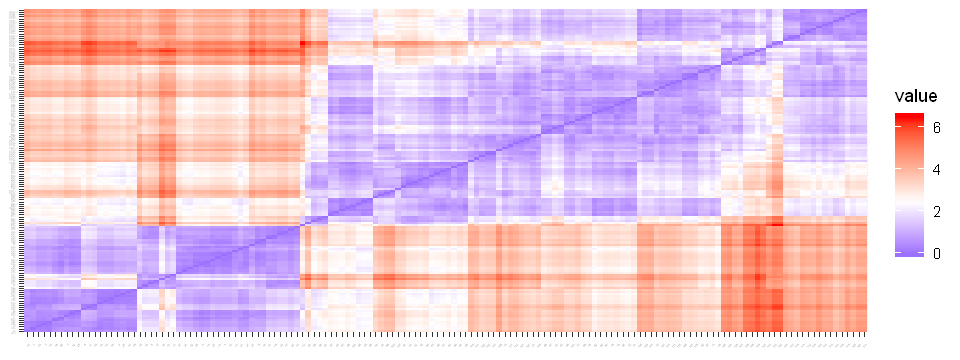

In [24]:
distance <- get_dist(iris_variables, method = "euclidean")
fviz_dist(distance, lab_size = 2, gradient = list(low = "blue", mid = "white", high = "red"))

#### Step 3 - Determine Optimal K-Value
I found two different ways to find optimal k-values for the k-means model. The first is using the fviz_nbclust option of the factoextra package. More about the function and package can be found here: https://www.rdocumentation.org/packages/factoextra/versions/1.0.7/topics/fviz_nbclust.

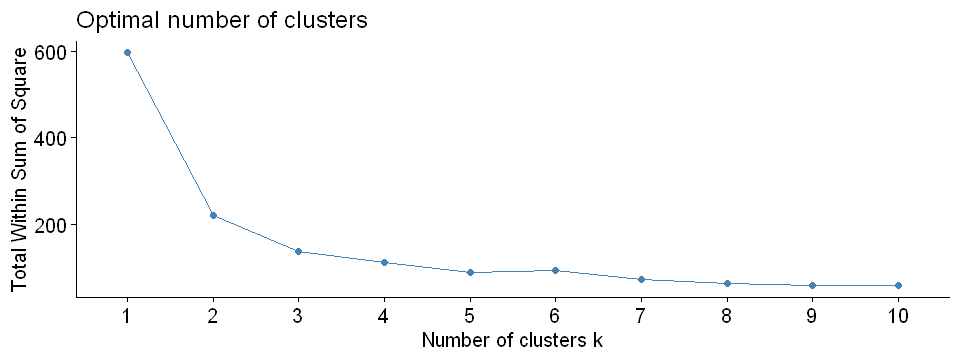

In [25]:
fviz_nbclust(iris_variables, kmeans, method = "wss")

The second method I found was to calculate the actual sum of squars error for each model using the kmeans function. By looping through the range of k-values I'm interested in checking and saving the sum of squares error to a dataframe and then plotting the values. I decided to use both methods so I can compare the results and see if I am able to produce the same results as the fviz_nbclust() function manually. I also added horizontal lines at each of the k-values to make it easier to see where the distance between sum of squares errors start to diminish.

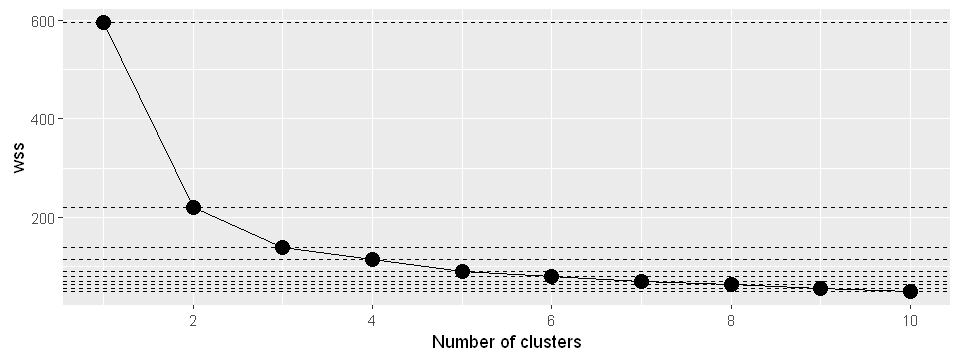

In [26]:
# Decide how many clusters to look at
n_clusters <- 10

# Initialize total within sum of squares error: wss
wss <- numeric(n_clusters)

set.seed(123)

# Look over 1 to n possible clusters
for (i in 1:n_clusters) {
  # Fit the model: km.out
  km.out <- kmeans(iris_variables, centers = i, nstart = 25)
  # Save the within cluster sum of squares
  wss[i] <- km.out$tot.withinss
}

# Produce a scree plot
wss_df <- tibble(clusters = 1:n_clusters, wss = wss)
 
scree_plot <- ggplot(wss_df, aes(x = clusters, y = wss, group = 1)) +
    geom_point(size = 4)+
    geom_line() +
    scale_x_continuous(breaks = c(2, 4, 6, 8, 10)) +
    xlab('Number of clusters')
scree_plot +
    geom_hline(
        yintercept = wss, 
        linetype = 'dashed')

Based on the above results It appears that the **best k-value is 3** since that is where the change in sum of squares starts to diminish. That also fits our data since we know their are three species we are wanting to classify.

#### Step 5 - Determine Importance of Predictors
Next I want to determine which of the four variables are most important for predicting the species. To do this I will compute a kmeans model using different combinations of variables and compare the clustering vector to the the expected results using a confusion matrix.

This wouldn't normally be something you would do for unsupervised learning, their wouldn't typically be a results variabl e.For most kmeans models you would analyze how well the model did at creating distinct clusters by comparing the the "within cluster sum of squares" between models. The main goal of kmeans clustering is to minimize the sum of distances between each data point and its assigned centroid, so you'd be looking for small values for the within cluster sum of squares (WCSS) or a large percentage for the between_SS / total_SS. This objective ensures that the clusters are compact and well-separated from each other. Below is a description of the outputs from the kmeans model and what they mean, I got this information from: https://andrea-grianti.medium.com/kmeans-parameters-in-rstudio-explained-c493ec5a05f.

In [27]:
combinations <- list(c(1), c(2), c(3), c(4), c(1, 2), c(1, 3), c(1, 4), c(2, 3), c(2, 4), 
                     c(3, 4), c(1, 2, 3) ,c(1, 2, 4), c(1, 3, 4), c(2, 3, 4), c(1, 2, 3, 4))

for (combo in combinations) {
    k_model <- kmeans(iris_variables[,combo], centers = 3, nstart = 25)
    cat("The variables being used:", combo)
    cm <- table(iris_data$Species, k_model$cluster)
    print(cm)
    cat("\n")

    # Use the largest value in each row as correct assignment
    correct_assignments <- apply(cm, 1, max)
    total_correct <- sum(correct_assignments)
    total_predictions <- sum(cm)

    # Accuracy calculation
    accuracy <- round((total_correct / total_predictions) * 100, 2)
    cat("Accuracy:", accuracy, "%", "\n\n")
}

The variables being used: 1            
              1  2  3
  setosa      0 45  5
  versicolor  9  6 35
  virginica  26  1 23

Accuracy: 70.67 % 

The variables being used: 2            
              1  2  3
  setosa      1 18 31
  versicolor 21 28  1
  virginica  11 34  5

Accuracy: 62 % 

The variables being used: 3            
              1  2  3
  setosa      0 50  0
  versicolor  2  0 48
  virginica  44  0  6

Accuracy: 94.67 % 

The variables being used: 4            
              1  2  3
  setosa      0  0 50
  versicolor  2 48  0
  virginica  46  4  0

Accuracy: 96 % 

The variables being used: 1 2            
              1  2  3
  setosa      0  1 49
  versicolor 14 36  0
  virginica  31 19  0

Accuracy: 77.33 % 

The variables being used: 1 3            
              1  2  3
  setosa      0 50  0
  versicolor  9  4 37
  virginica  34  0 16

Accuracy: 80.67 % 

The variables being used: 1 4            
              1  2  3
  setosa      0 50  0
  versicolor  6  4 40


Interestengly enough, what I see is that the best results come from just using variable 4 (Petal.Width). When you look at the confusion matrix you can see that it correctly predicted all of the setosa, 48 of the versicolor, and 46 of the virginica. So the **Petal Width is the most important variable for predicting flower species** and when using just that variable to create a cluster model we see that it "correctly" clusters 96% of the flower species.

#### Step 6 - Analyze Results
Now that I have determined that a k-value of 3 will create the best kmeans model I will analyze it's performance. Even though I found that using just the petal width created the best prediction for flower species, I am going to create a model with all four variables and a model with with just the Petal Width. Since the kmeans model isn't typically used for supervised learning I'm interested in seeing what the results would look like if I didn't have the species data.

##### Model w/ All 4 Variables
I'm going to start with the model that has all 4 variables. The first step is creating the new kmeans models and then printing it's output for analysis.

In [28]:
k3 <- kmeans(iris_variables, centers = 3, nstart = 25)
k3

K-means clustering with 3 clusters of sizes 47, 53, 50

Cluster means:
  Sepal.Length Sepal.Width Petal.Length Petal.Width
1   1.13217737  0.08812645    0.9928284   1.0141287
2  -0.05005221 -0.88042696    0.3465767   0.2805873
3  -1.01119138  0.85041372   -1.3006301  -1.2507035

Clustering vector:
  [1] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [38] 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2
 [75] 2 1 1 1 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 2 1 1 1 1
[112] 1 1 2 2 1 1 1 1 2 1 2 1 2 1 1 2 1 1 1 1 1 1 2 2 1 1 1 2 1 1 1 2 1 1 1 2 1
[149] 1 2

Within cluster sum of squares by cluster:
[1] 47.45019 44.08754 47.35062
 (between_SS / total_SS =  76.7 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

What I can see is that the model has cluster sum of squares that are ~45 in value and the (between_SS / total_SS) is 76.7%. When I reviewed literature on interpretting results from a kmeans model it indicated that these values really depend on the dataset you are analyzing to understand how good of a job it has done in creating clusters. All I can do is compare the values to other models on the same dataset since I don't have the experience to know what I should expect for the dataset.

Next I want to visualize the results. The fviz_cluster() function visualizes the cluster in 2 dimensions. However, since we have 4 dimensions fviz_cluster() performs Principle Components Analysis (PCA) behind the scenes to reduce the dimensions such that data can be represented by clusters in a 2-D space.

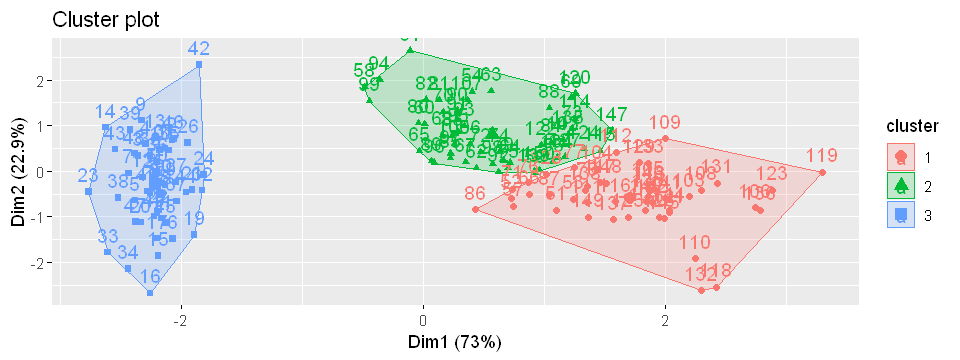

In [29]:
fviz_cluster(k3, data = iris_variables)

It does appear that the model creates three distinct clusters without overlap. There is similarities between clusters 1 (versicolor) and 3 (virginica) that explain why my model struggles to distinguish between versicolor and virginica.

By creating a confusion matrix I can see how the results of the kmeans model compare to the species listed in the original dataset. It also lets me know that for the model cluster 1 = versicolor, cluster 2 = setosa, and cluster 3 = virginica.

In [30]:
cm <- table(iris_data$Species, k3$cluster)
cm

            
              1  2  3
  setosa      0  0 50
  versicolor 11 39  0
  virginica  36 14  0

As seen by the confusion matrix, the model correctly classifies all of the setosa but struggles to distinguish between the versicolor and virginica.


It helped me to visualize the clustering alongside the original data so I added the cluster output to the iris_data. To keep the file from getting too long I only displayed the first 6 rows.

In [31]:
iris_data$cluster = k3$cluster
head(iris_data)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,cluster
5.1,3.5,1.4,0.2,setosa,3
4.9,3.0,1.4,0.2,setosa,3
4.7,3.2,1.3,0.2,setosa,3
4.6,3.1,1.5,0.2,setosa,3
5.0,3.6,1.4,0.2,setosa,3
5.4,3.9,1.7,0.4,setosa,3


##### Model W/ Just Petal Width
Next I want to look at the model that just uses the Petal Width to create clusters. I started by creating a new model and displaying it's output for analysis. I decided not to use the standardized data since we are only looking at the one variable. Looking at both versions this didn't seem to impact the results of the mode at all.

In [32]:
k3_pw <- kmeans(iris_data[,4], centers = 3, nstart = 25)
k3_pw

K-means clustering with 3 clusters of sizes 52, 48, 50

Cluster means:
      [,1]
1 1.323077
2 2.058333
3 0.246000

Clustering vector:
  [1] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [38] 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 [75] 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
[149] 2 2

Within cluster sum of squares by cluster:
[1] 1.692308 2.676667 0.544200
 (between_SS / total_SS =  94.3 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

What I can see is that the model has cluster sum of squars that are ~2 in value and the (between_SS / total_SS) is 94.3%. Comparing this to the model with all four variables we see that we get much better results.  This means that if you imagine a cluster like a cloud of points that have a distance from the centroid, the sum of squares of the distances of the points assigned to a cluster from the centroid of that cluster. Since they are small it indicates that we have fairly good clusters that aren't close to overlapping the other clusters.

Next I want to visualize the results. Since this model only has the one variable I can plot the distribution of clusters as a scatter plot along the y = 0 axis. I added the geom_jitter(height = 0.01) function to the plot which introduces some random noise to the y-axis positions of the points, preventing overlap and ensuring better visibility of all data points. I found that without this the points were not very distinct within each cluster.

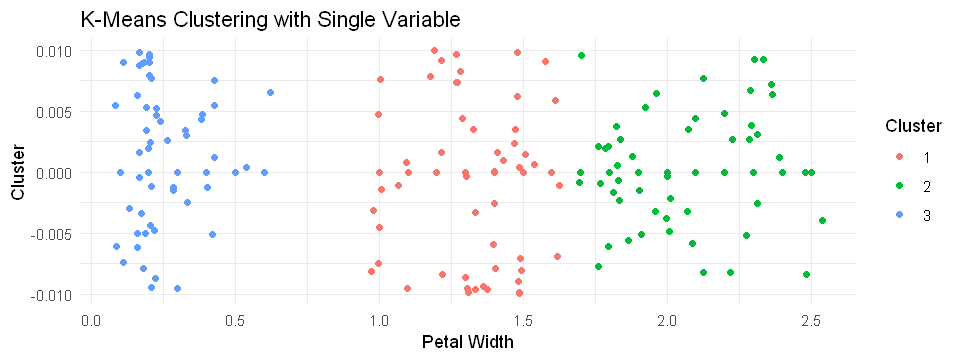

In [33]:
# Create a data frame with the variable and cluster assignment
data_for_plot <- data.frame(Petal.Width = iris_data[, 4],
                            Cluster = as.factor(k3_pw$cluster))

# Plot the clusters
ggplot(data_for_plot, aes(x = Petal.Width, y=0, color = Cluster)) +
  geom_jitter(height = .01) +
  geom_point() +
  labs(title = "K-Means Clustering with Single Variable",
       x = "Petal Width", y = "Cluster") +
  theme_minimal()

The scatterplot clearly shows the three clusters that were created and where it is deliniating each cluster. It appears that cluster 2 (setosa) have pedal widths less than ~0.7, cluster 1 (virginica) has petal widths between 0.9 and 1.625, and cluster 3 (versicolor) has petal widths greater than 1.625. Looking at the data this seems to hold true with a few exceptions for the versicolor and virginica which explains why we had 6 misclassifications using this model.


Finally, I want to visualize the results in a confusion matrix which can be seen below!

In [34]:
cm_pw <- table(iris_data$Species, k3_pw$cluster)
cm_pw

            
              1  2  3
  setosa      0  0 50
  versicolor 48  2  0
  virginica   4 46  0